In [29]:
import sys
sys.path.append('../')

import thermonets as tn
import numpy as np
import heyoka as hy
import pykep as pk
from nrlmsise00 import msise_flat
import spaceweather
from datetime import datetime
import pygmo as pg
import pyatmos

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## NRLMSISE -00 
We call first nrlmsise-00 model 

In [12]:
altitudes = np.logspace(2.2,2.8,50)
lats =  np.linspace(-90., 90., 10) 
lon = 60
f107A = 150.
f107 = 150.
ap = 4.
rho_nrlmsise00 = msise_flat(datetime(2009, 6, 21, 8, 3, 20), altitudes[None,:], lats[:,None], lon, f107A, f107, ap)[:,:,5] * 1e3

## JB-08 

We do the same w JB-08

In [14]:
#we prepare the necessary information for calling JB-08 model:
#first the space weather data
swfile = pyatmos.download_sw_jb2008()
swdata = pyatmos.read_sw_jb2008(swfile)
#then the date
date = datetime(2010, 6, 21, 8, 3, 20)

rho_jb08 = np.zeros((len(lats),len(altitudes)))
for j in range(len(altitudes)):
    for i in range(len(lats)):
        rho_jb08[i,j]=pyatmos.jb2008(date,(lats[i], lon, altitudes[j]), swdata).rho

The Space Weather files 'SOLFSMY.TXT' and 'DTCFILE.TXT' in /Users/ga00693/src/sw-data/ are already the latest.


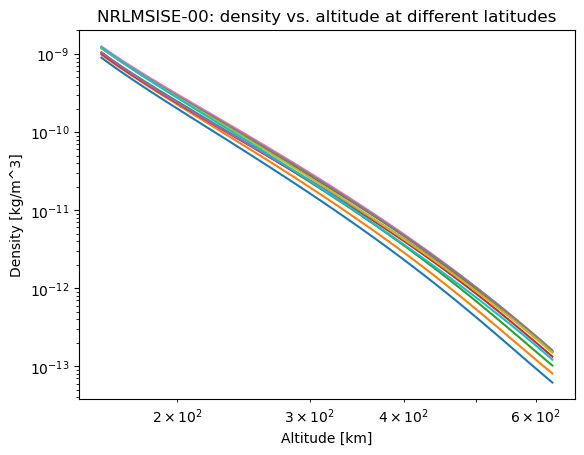

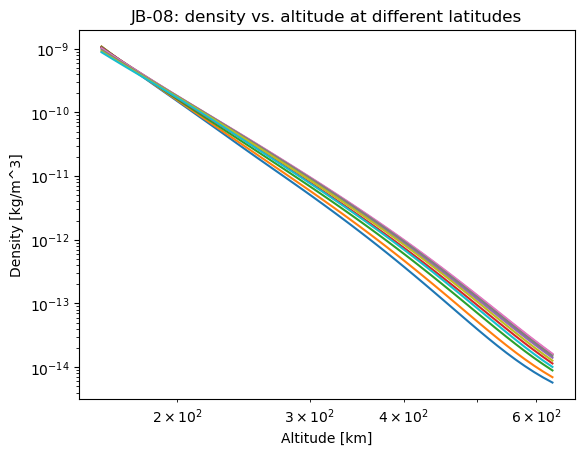

In [17]:
plt.loglog(altitudes, rho_nrlmsise00.T)
plt.title("NRLMSISE-00: density vs. altitude at different latitudes")
plt.xlabel("Altitude [km]")
plt.ylabel("Density [kg/m^3]");

plt.figure()
plt.loglog(altitudes, rho_jb08.T)
plt.title("JB-08: density vs. altitude at different latitudes")
plt.xlabel("Altitude [km]")
plt.ylabel("Density [kg/m^3]");


Lets fit the data with our formula for both models.

In [26]:
target = 7
udp_nrlmsise00 = tn.global_fit_udp(altitudes, rho_nrlmsise00[target,:], n=4)
prob_nrlmsise00 = pg.problem(udp_nrlmsise00)

udp_jb08 = tn.global_fit_udp(altitudes, rho_jb08[target,:], n=4)
prob_jb08 = pg.problem(udp_jb08)

In [33]:
uda = pg.sade(50, memory=True, )

algo_nrlmsise00 = pg.algorithm(uda)
pop_nrlmsise00  =pg.population(prob_nrlmsise00, 30)

algo_jb08 = pg.algorithm(uda)
pop_jb08  =pg.population(prob_jb08, 30)

In [34]:
for i in range(500):
    pop_nrlmsise00 = algo_nrlmsise00.evolve(pop_nrlmsise00)
    pop_jb08 = algo_jb08.evolve(pop_jb08)
print("For NRLMSISE-00 we achieved: ", pop_nrlmsise00.champion_f)
print("For JB-08 we achieved: ", pop_jb08.champion_f)

For NRLMSISE-00 we achieved:  [0.00078099]
For JB-08 we achieved:  [0.00039666]


Text(0, 0.5, 'Density [kg/m^3]')

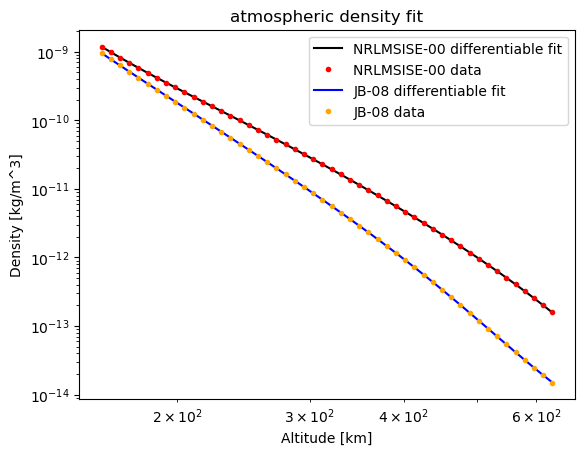

In [37]:
plt.figure()
plt.loglog(altitudes, tn.rho_approximation(altitudes, pop_nrlmsise00.champion_x), color='black',label ='NRLMSISE-00 differentiable fit')
plt.loglog(altitudes, rho_nrlmsise00[target,:], '.', color='r', label='NRLMSISE-00 data')
plt.loglog(altitudes, tn.rho_approximation(altitudes, pop_jb08.champion_x), color='blue', label ='JB-08 differentiable fit')
plt.loglog(altitudes, rho_jb08[target,:], '.', color='orange', label='JB-08 data')
plt.legend()
plt.title("atmospheric density fit")
plt.xlabel("Altitude [km]")
plt.ylabel("Density [kg/m^3]")

We repeat for all different lats.

In [38]:
best_x_nrlmsise00 = []
best_f_nrlmsise00 = []
best_x_jb08 = []
best_f_jb08 = []
for target in range(10):
    udp_nrlmsise00 = tn.global_fit_udp(altitudes, rho_nrlmsise00[target, :], n=4)
    udp_jb08 = tn.global_fit_udp(altitudes, rho_jb08[target, :], n=4)

    prob_nrlmsise00 = pg.problem(udp_nrlmsise00)
    prob_jb08 = pg.problem(udp_jb08)
    
    uda = pg.sade(50, memory=True)
    
    algo_nrlmsise00 = pg.algorithm(uda)
    algo_jb08 = pg.algorithm(uda)
    
    pop_nrlmsise00 = pg.population(prob_nrlmsise00, 30)
    pop_jb08 = pg.population(prob_jb08, 30)
    
    for i in range(1000):
        pop_nrlmsise00 = algo_nrlmsise00.evolve(pop_nrlmsise00)
        pop_jb08 = algo_jb08.evolve(pop_jb08)
    print("For sample  ", target, " NRLMSISE-00 achieved: ", pop_nrlmsise00.champion_f, " JB-08 achieved: ", pop_jb08.champion_f, flush=True)
    best_x_nrlmsise00.append(pop_nrlmsise00.champion_x)
    best_f_nrlmsise00.append(pop_nrlmsise00.champion_f)
    best_x_jb08.append(pop_jb08.champion_x)
    best_f_jb08.append(pop_jb08.champion_f)

For sample   0  NRLMSISE-00 achieved:  [0.00071906]  JB-08 achieved:  [0.00133747]
For sample   1  NRLMSISE-00 achieved:  [0.00148893]  JB-08 achieved:  [0.00089298]
For sample   2  NRLMSISE-00 achieved:  [0.00041652]  JB-08 achieved:  [0.0009222]
For sample   3  NRLMSISE-00 achieved:  [0.0013801]  JB-08 achieved:  [0.00040999]
For sample   4  NRLMSISE-00 achieved:  [0.00158412]  JB-08 achieved:  [0.00298675]
For sample   5  NRLMSISE-00 achieved:  [0.00159653]  JB-08 achieved:  [0.00078173]
For sample   6  NRLMSISE-00 achieved:  [0.00148855]  JB-08 achieved:  [0.00207795]
For sample   7  NRLMSISE-00 achieved:  [0.00041489]  JB-08 achieved:  [0.00146596]
For sample   8  NRLMSISE-00 achieved:  [0.00030501]  JB-08 achieved:  [0.00077391]
For sample   9  NRLMSISE-00 achieved:  [0.00113639]  JB-08 achieved:  [0.00115536]


## NRLMSISE-00 plots

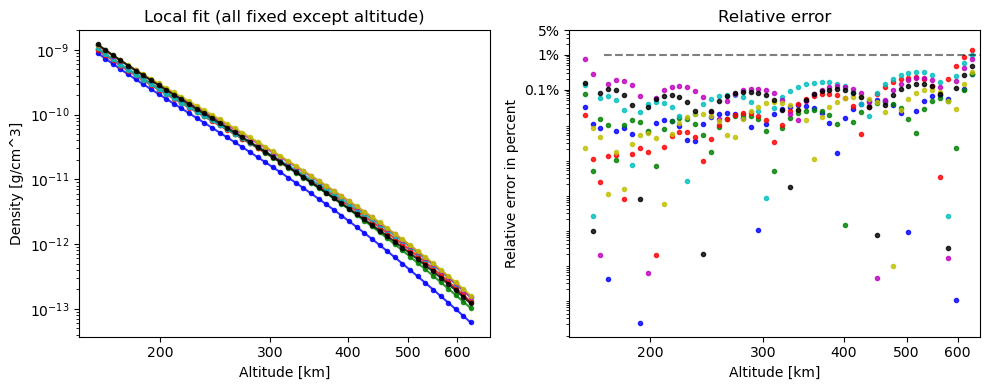

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
colors = ["b", "g", "r", "c", "m", "y","k"]

for j, i in enumerate([0, 2, 3,4, 5, 7, 9]):
    ax[0].loglog(altitudes, tn.rho_approximation(altitudes, best_x_nrlmsise00[i]), c=colors[j], alpha=0.8)
    ax[0].loglog(altitudes, rho_nrlmsise00[i, :], ".", c=colors[j], alpha=0.8)

ax[0].set_title("Local fit (all fixed except altitude)")
ax[0].set_xlabel("Altitude [km]")
ax[0].set_ylabel("Density [g/cm^3]")
ax[0].set_xticks([200, 300, 400,500, 600], ["200", "300", "400", "500", "600"])


for j, i in enumerate([0, 2, 3,4, 5, 7, 9]):
    rel_err = (tn.rho_approximation(altitudes, best_x_nrlmsise00[i]) - rho_nrlmsise00[i, :]) / np.linalg.norm(
        rho_nrlmsise00[:, :], axis=0
    )
    ax[1].loglog(altitudes, 100 * np.abs(rel_err), '.', c=colors[j], alpha=0.8)
ax[1].set_title("Relative error")
ax[1].set_xlabel("Altitude [km]")
ax[1].set_ylabel("Relative error in percent")

ax[1].set_xlim([150,650])
ax[1].vlines(150, 1e-8, 10, 'k', linestyle='--', alpha=0.5)
ax[1].hlines(1, 170, 1500, 'k', linestyle='--', alpha=0.5)

ax[1].set_yticks([5, 1, 0.1], ["5%", "1%", "0.1%"])
ax[1].set_xticks([200, 300, 400,500, 600], ["200", "300", "400", "500", "600"])

plt.tight_layout()
plt.savefig("rho_error_nrlmsise00", dpi=600)

## JB-08 plots

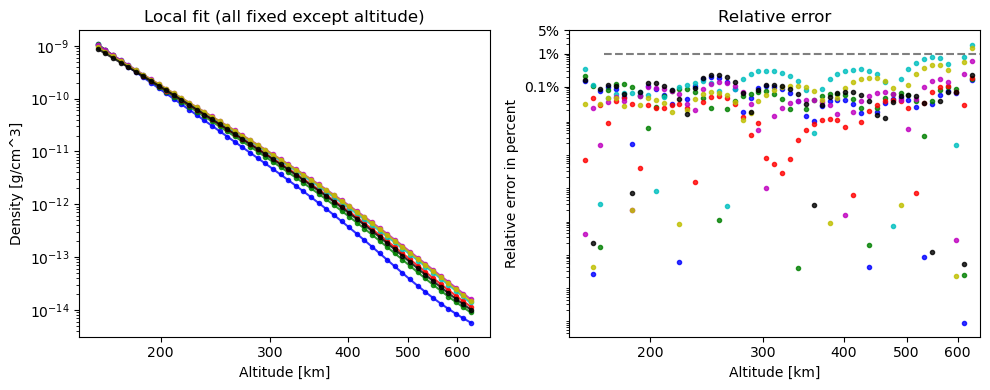

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
colors = ["b", "g", "r", "c", "m", "y","k"]

for j, i in enumerate([0, 2, 3,4, 5, 7, 9]):
    ax[0].loglog(altitudes, tn.rho_approximation(altitudes, best_x_jb08[i]), c=colors[j], alpha=0.8)
    ax[0].loglog(altitudes, rho_jb08[i, :], ".", c=colors[j], alpha=0.8)

ax[0].set_title("Local fit (all fixed except altitude)")
ax[0].set_xlabel("Altitude [km]")
ax[0].set_ylabel("Density [g/cm^3]")
ax[0].set_xticks([200, 300, 400,500, 600], ["200", "300", "400", "500", "600"])


for j, i in enumerate([0, 2, 3,4, 5, 7, 9]):
    rel_err = (tn.rho_approximation(altitudes, best_x_jb08[i]) - rho_jb08[i, :]) / np.linalg.norm(
        rho_jb08[:, :], axis=0
    )
    ax[1].loglog(altitudes, 100 * np.abs(rel_err), '.', c=colors[j], alpha=0.8)
ax[1].set_title("Relative error")
ax[1].set_xlabel("Altitude [km]")
ax[1].set_ylabel("Relative error in percent")

ax[1].set_xlim([150,650])
ax[1].vlines(150, 1e-8, 10, 'k', linestyle='--', alpha=0.5)
ax[1].hlines(1, 170, 1500, 'k', linestyle='--', alpha=0.5)

ax[1].set_yticks([5, 1, 0.1], ["5%", "1%", "0.1%"])
ax[1].set_xticks([200, 300, 400,500, 600], ["200", "300", "400", "500", "600"])

plt.tight_layout()
plt.savefig("rho_error_jb08", dpi=600)

All in all we conclude that the analytical formula is capable to capture well the density trend with the altitude, fixing all other values.